## <u>Notebook Synopsis:</u> In the previous notebook, I created a number of data sets from the larger nomad data set pre-processed 2 notebooks prior. In this notebook I load the subset intended for this project

In [1]:
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [29]:
#import pymc3 as pm

#import arviz as ar
import matplotlib.pyplot as pl
from matplotlib import rcParams
#import seaborn as sb
%matplotlib inline

In [30]:
rcParams['axes.formatter.limits'] = (-2, 3)
rcParams['axes.labelsize'] = 16
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16

## Methods

The dataset used in this study was generated from the NOMAD dataset. 6 Rrs bands were used at 6 wavelength corresponding to SeaWiFS spectral coverage; 412, 443, 490, 510, 555, 670 nm. Of these, only 443 - 555 nm bands were retained. In this notebook, the following data transformation/feature engineering steps are implemented:

* for band ratio algorithms, relevant ratios are pre-computed;
* for band ratio algorithms with max(Blue) formulation, blue band used in the ratio is identified and flagged for grouping in partially pooled models
* reflectances, reflectance ratios and chlorophyll are log-transformed;
* for PCA-based algorithms, principal components were computed for all bands.
* chlorophyll measurement method (hplc or not) zasu7ZL/.%T'            s identified and flagged
* all predictors are standardized for more efficient 

In [3]:
df_ = pd.read_pickle('./pickleJar/df_nopurple_nored.pkl')

### Compute band ratios, along with blue band used in the ratio, and an integer index to the same for use in partial pooling models:

In [4]:
insert_loc = df_.columns.get_loc('chlor_a')
blue_cols = ['rrs443', 'rrs489', 'rrs510']
df_.insert(insert_loc, 'MaxBlue', df_[blue_cols].max(axis=1))
insert_loc += 1
df_.insert(insert_loc, 'MaxBlueBand', df_[blue_cols].idxmax(axis=1).str.capitalize())
insert_loc += 1
df_.insert(insert_loc,'MaxBlueBandIdx',
           pd.Categorical(df_.MaxBlueBand, categories=blue_cols,).codes)
insert_loc += 1
df_.insert(insert_loc, 'mxBlue2Gr', df_.MaxBlue / df_.rrs555)

In [5]:
df_.head()

,id,rrs443,rrs489,rrs510,rrs555,MaxBlue,MaxBlueBand,MaxBlueBandIdx,mxBlue2Gr,chlor_a,is_hplc
0,1565,0.001686,0.003293,0.004036,0.007479,0.004036,Rrs510,-1,0.539676,38.19,False
1,1566,0.001384,0.002173,0.002499,0.004152,0.002499,Rrs510,-1,0.601926,35.01,False
2,1567,0.001185,0.001843,0.002288,0.004246,0.002288,Rrs510,-1,0.538844,26.91,False
3,1568,0.001741,0.002877,0.003664,0.006982,0.003664,Rrs510,-1,0.524837,47.96,False
4,1559,0.001022,0.001506,0.001903,0.002801,0.001903,Rrs510,-1,0.679622,23.55,False


In [6]:
df_.to_pickle('./pickleJar/df_nopurple_nored_with_MBR.pkl')

### Log-transforming reflectances, ratios, and chlor_a

In [24]:
columns_to_log_transform = df_.filter(regex='(rrs|chl|mxBlue2)',
                                         axis=1).columns.tolist()

# log_transforms
df_log = pd.DataFrame(np.log10(df_.loc[:,
                                            columns_to_log_transform
                                           ].values),
                      columns=[f'log_{col}' 
                               for col in columns_to_log_transform])

Note on computing sd on log scale:


If Var(exp(log_rrs))≈exp$(\mu_{log\_rrs})^2\sigma^2_{log\_rrs}$

$sd(exp(log\_rrs))≈exp(\mu_{log\_rrs})\sigma_{log\_rrs}$


$\leftrightarrow \ \sigma_{log\_rrs} ≈ \frac{sd(rrs)}{exp(\mu_{log\_rrs})}$

In [25]:
df_log.head()

,log_rrs443,log_rrs489,log_rrs510,log_rrs555,log_mxBlue2Gr,log_chlor_a
0,-2.773122,-2.482397,-2.394012,-2.126145,-0.267867,1.581950
1,-2.858857,-2.662956,-2.602191,-2.381734,-0.220457,1.544192
2,-2.926105,-2.734427,-2.640597,-2.372060,-0.268537,1.429914
3,-2.759143,-2.541014,-2.436014,-2.156039,-0.279976,1.680879
4,-2.990409,-2.822196,-2.720468,-2.552735,-0.167733,1.371991


In [26]:
df_log.insert(0, 'id', df_.id)
df_log.insert(df_log.columns.get_loc('log_mxBlue2Gr'), 
             'MaxBlueBand', df_.MaxBlueBand)
df_log['is_hplc'] = df_.is_hplc

df_log = df_log[['id', 'log_rrs443', 'log_rrs489', 'log_rrs510', 'log_rrs555',
                 'MaxBlueBand', 'log_mxBlue2Gr', 'log_chlor_a', 'is_hplc']]

df_log.head()

,id,log_rrs443,log_rrs489,log_rrs510,log_rrs555,MaxBlueBand,log_mxBlue2Gr,log_chlor_a,is_hplc
0,1565,-2.773122,-2.482397,-2.394012,-2.126145,Rrs510,-0.267867,1.581950,False
1,1566,-2.858857,-2.662956,-2.602191,-2.381734,Rrs510,-0.220457,1.544192,False
2,1567,-2.926105,-2.734427,-2.640597,-2.372060,Rrs510,-0.268537,1.429914,False
3,1568,-2.759143,-2.541014,-2.436014,-2.156039,Rrs510,-0.279976,1.680879,False
4,1559,-2.990409,-2.822196,-2.720468,-2.552735,Rrs510,-0.167733,1.371991,False


In [27]:
df_log.describe()

,id,log_rrs443,log_rrs489,log_rrs510,log_rrs555,log_mxBlue2Gr,log_chlor_a
count,4459.000000,4456.000000,4422.000000,3435.000000,3255.000000,3255.000000,4127.000000
mean,4377.381251,-2.421040,-2.395443,-2.447466,-2.611693,0.278669,-0.112459
std,2298.272102,0.292499,0.224659,0.220647,0.292241,0.310451,0.687956
min,6.000000,-3.721171,-3.546531,-3.583095,-3.737064,-0.398402,-1.920819
25%,2028.500000,-2.582159,-2.515600,-2.548050,-2.799234,0.020759,-0.632039
50%,5039.000000,-2.409061,-2.381635,-2.465355,-2.683803,0.228030,-0.116907
75%,6271.500000,-2.216361,-2.247581,-2.372431,-2.502876,0.534595,0.332438
max,7831.000000,-1.434521,-1.195083,-1.109354,-1.331613,1.010287,1.891341


In [28]:
df_log.to_pickle('./pickleJar/df_log_nopurple_nored_with_MBR.pkl')

### Computing Principal Components

In [31]:
#Compute PC for all bands, for PCA-based regression algorithms
pc_transformer = PCA()
PCs = pc_transformer.fit_transform(df_log.filter(regex='rrs',
                                                 axis=1).dropna()
                                  )
df_pc = pd.DataFrame(PCs, columns = [f'pc{i+1}' 
                                     for i in range(PCs.shape[1])])

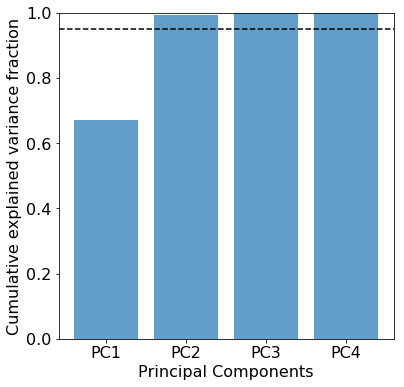

In [34]:
# Plotting explained variance of principle components
_, ax = pl.subplots(figsize=(6, 6))
ax.bar([f'PC{i}' for i in range(1, 5)],
       np.cumsum(pc_transformer.explained_variance_ratio_), alpha=0.7);
ax.set_ylabel('Cumulative explained variance fraction')
ax.set_xlabel('Principal Components');
ax.set_ylim(0, 1)
ax.axhline(0.95, color='k', ls='--');

In [35]:
df_pc.to_pickle('./pickleJar/df_pca_from_log_nopurple_nored_with_MBR.pkl')

Before a principled statistical comparison of the different chlorophyll algorithms becomes possible, the different algorithms must be re-implemented using a Bayesian framework. The implementation follows the sequence below:

* Model coding using a probabilistic programming language (PPL)
* Prior predictive simulation 
* Model fitting using Hamiltonian Monte Carlo and the Nomad dataset
* Posterior predictive simulation to quantify predictive uncertainty
* Comparison of Model skill  on out-of-sample data using Information Criteria (IC) including Watanabe Akaike Information Criterion (WAIC) and/or Pareto Smoothed Importance Sampling Leave One Out Cross Validation (LOO).


1. Implementation of $OC_4$ 


    A. Without chlorophyll measurement error

In [24]:
X = df_log.log_mxBlu2Gr.values
y = df_log.log_chlor_a.values
X_poly = np.c_[X, np.power(X, 2), np.power(X, 3), np.power(X, 4)]

In [25]:
X_poly.shape

(1016, 4)

In [32]:
with pm.Model() as m_oc4:
    α = pm.Normal('α', 0, 1)
    β = pm.Normal('β', 0, 1, shape=X_poly.shape[1])
    σ = pm.Exponential('σ', 1)
    μ =  α + pm.math.dot(X_poly, β)
    log_chl = pm.Normal('log_chl', mu=μ, sd=σ, observed=y)

In [33]:
render = pm.model_to_graphviz(m_oc4)

In [34]:
render.render('m_oc4', directory='./figJar', format='png');

<img src='./figJar/m_oc4.png?:0' />

In [37]:
m_oc4_priors = pm.sample_prior_predictive(model=m_oc4,
                                         vars=['α', 'β', 'σ', 'log_chl'])

In [38]:
α_prior = m_oc4_priors['α']
β_prior = m_oc4_priors['β']
σ_prior = m_oc4_priors['σ']
log_chl_prior = m_oc4_priors['log_chl']

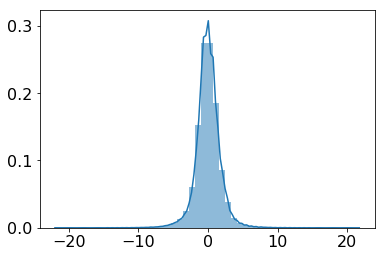

In [42]:
f, ax = pl.subplots(figsize=(6, 4))
sb.distplot(log_chl_prior.flatten(),
            hist_kws={'alpha': 0.5})
sb.distplot(log_chl_prior.flatten(), )

In [45]:
with m_oc4:
    trace_oc4 = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, β, α]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:19<00:00, 310.80draws/s]


In [49]:
m_oc4_posteriors = {k: trace_oc4.get_values(k) for k in ['α', 'β', 'σ']}

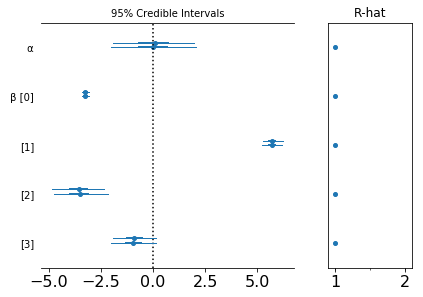

In [47]:
pm.forestplot(trace_oc4, varnames=['α', 'β']);

    B. With chlorophyll measurement error

2. Implementation of $OC_x$ with $CI$ split


    A. Without chlorophyll measurement error

In [ ]:
with pm.Model() as m_oci:
    \alpha

    B. With chlorophyll measurement error

3. Simple band ratio

    A. Without chlorophyll measurement error

    B. With chlorophyll measurement error

4. Multivariate Linear Regression


    A. Without chlorophyll measurement error

    B. With chlorophyll measurement error

5. Multivariate Linear Regression with Prior Transformation of Principal Components of Reflectance

    A. Without chlorophyll measurement error

    B. With chlorophyll measurement error